<a href="https://colab.research.google.com/github/katearb/ipynb-projects/blob/master/w4_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, log_loss, f1_score, make_scorer, precision_score
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from scipy.stats import chi2_contingency

from IPython.display import display

random.seed(10)

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/katearb/files/main/dataset_hypothyroid.csv')

In [3]:
data_no_na = pd.read_csv('https://raw.githubusercontent.com/katearb/files/main/dataset_hypothyroid.csv',
                         na_values='?')
data_no_na = data_no_na.drop(['TBG', 'TBG_measured'], axis=1).dropna()

data_no_na is needed for EDA to draw graphs correctly, as it is problematic, for example, to build graph for numeric columns when there are NANs as it is impossible to convert to float/int types etc. It won't be used for modeling.

# 1. EDA

## step 1. General information about the dataset

In [ ]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,negative


In [ ]:
data.shape

(3772, 30)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on_thyroxine               3772 non-null   object
 3   query_on_thyroxine         3772 non-null   object
 4   on_antithyroid_medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid_surgery            3772 non-null   object
 8   I131_treatment             3772 non-null   object
 9   query_hypothyroid          3772 non-null   object
 10  query_hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

All the features are represented by object-type, but from data.head() it gets clear that there are some numeric features, which could be represented by float or int (e.g. age or TSH).
* Changing data type is needed.

Most of the variables seem to be boolean and correspond to presens of a particular symptom, disease, or feature of the body.
* Encoding is needed.

In [5]:
# make data type as it should be
# replace ? with -1 allows us to transform data type from object to int/float
def encode_binary(data: pd.DataFrame,
                  columns: list):
  for column in columns:
    if column == 'sex':
      data[column] = data[column].map({'M': 1, 'F': 0, '?': -1}).astype('int')
    else:
      data[column] = data[column].map({'t': 1, 'f': 0, '?': -1}).astype('int')

  return

def encode_target(data: pd.DataFrame):
  data['Class'] = data['Class'].map({'negative': 0, 
                                     'primary_hypothyroid': 1, 
                                     'secondary_hypothyroid': 3,
                                     'compensated_hypothyroid': 2})
  return
  
def type_numeric(data: pd.DataFrame,
                 columns: list):
  for column in columns:
    data[column] = data[column].replace('?', -1)

    if column == 'age':
      data[column] = data[column].astype('int')
    else:
      data[column] = data[column].astype('float')
  
  return

def fix_datatype(data: pd.DataFrame,
                 bin_columns: list,
                 numeric_columns: list):
    new_data = data.copy()
    encode_binary(new_data, bin_columns)
    encode_target(new_data)
    type_numeric(new_data, numeric_columns)

    return new_data

In [71]:
# define columns types and group them
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
cat_column = 'referral_source'
target = 'Class'
bin_columns = [col for col in data.columns if (col not in numeric_columns) and col not in [cat_column, target]]
bin_columns_no_na =  [col for col in data_no_na.columns if (col not in numeric_columns) and col not in [cat_column, target]]
non_numeric = bin_columns + [cat_column] + [target]

# reverse mapping for the target
reverse_mapping = {0: 'negative', 
                   1: 'prim_hypothyroid', 
                   2: 'sec_hypothyroid',
                   3: 'comp_hypothyroid'}

In [7]:
data_no_na = fix_datatype(data_no_na, bin_columns_no_na, numeric_columns)

## Step 2. Missing values.

In [ ]:
# count Nans
data.replace('?', np.nan).isnull().sum().sort_values(ascending=False)

TBG                          3772
T3                            769
T4U                           387
FTI                           385
TSH                           369
TT4                           231
sex                           150
age                             1
query_hypothyroid               0
I131_treatment                  0
thyroid_surgery                 0
pregnant                        0
on_antithyroid_medication       0
sick                            0
lithium                         0
query_on_thyroxine              0
on_thyroxine                    0
query_hyperthyroid              0
Class                           0
goitre                          0
tumor                           0
referral_source                 0
psych                           0
TSH_measured                    0
T3_measured                     0
TT4_measured                    0
T4U_measured                    0
FTI_measured                    0
TBG_measured                    0
hypopituitary 

In [ ]:
print('Number of samples with many Nans:', len(data[data['T4U'] == '?'][data['FTI'] == '?'][data['TSH'] == '?'][data['TT4'] == '?']))

Number of samples with many Nans: 203


Observations:
1. TBG feature is 100% missed --> delete on DP step.
2. T3 feature has ~20% missed values, which is a pretty big number. Taking into account that we have many features, it might be considered no to use this feature either if it doesn't improve prediction much.
3. In some other features, there are ~360 NANs, which is not enough to remove features, but still is too big for sample removal. The sets of observations with these omissions intersect, i.e. there are ~200 samples with many missing features.  --> impute on DP step.

## Step 3. Univariate analysis

### 3.1  explore values proportion of categorical features

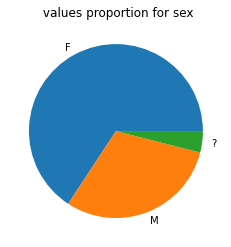

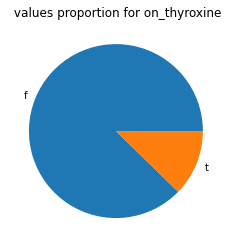

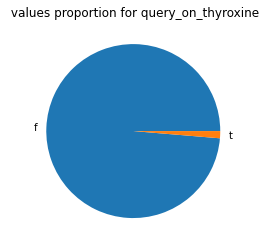

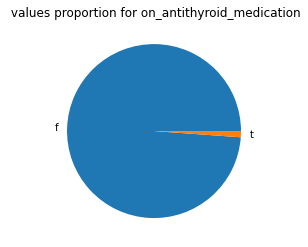

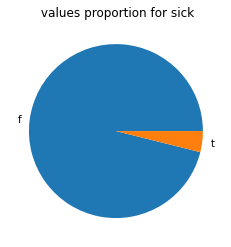

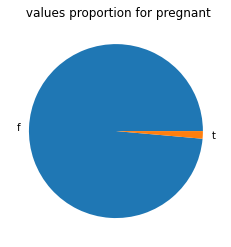

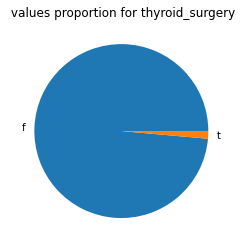

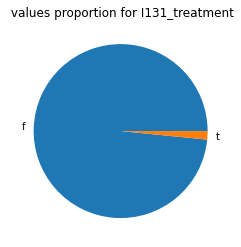

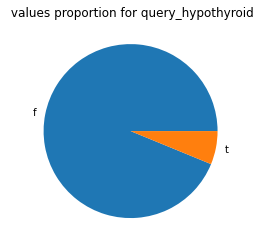

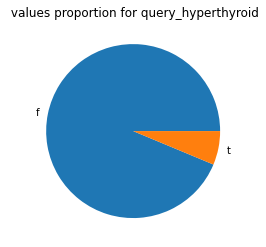

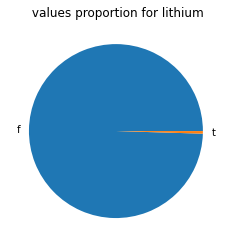

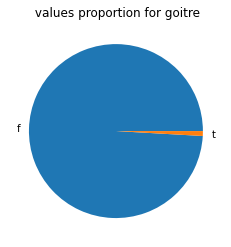

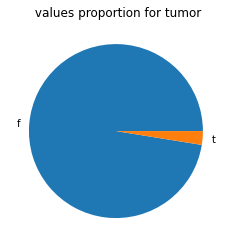

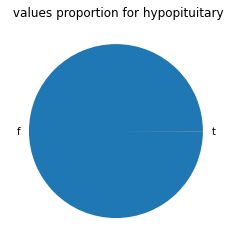

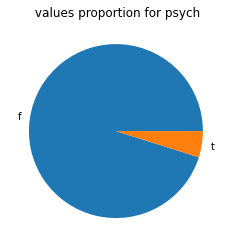

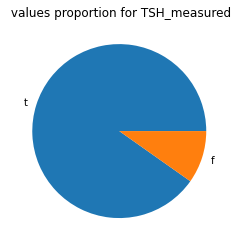

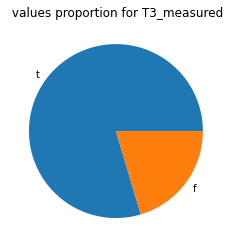

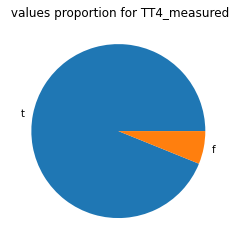

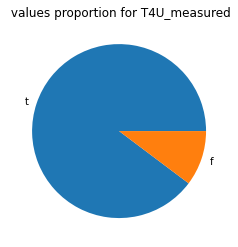

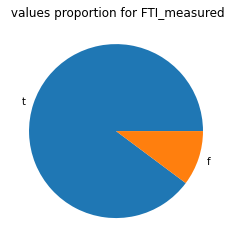

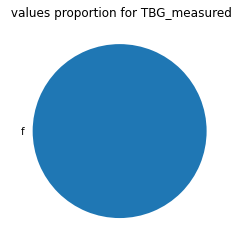

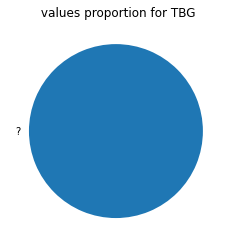

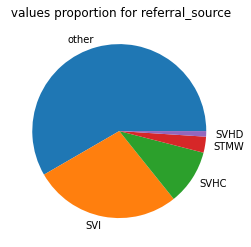

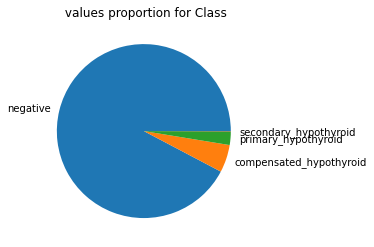

In [ ]:
for column in non_numeric:
  pie_info = data[column].value_counts()
  labels = pie_info.index
  plt.pie(pie_info, labels=labels)
  plt.title(f' values proportion for {column}')
  plt.show()

As many binary features have low variance, it might be considered to remove them better. However, even rare "t" values may be important for prediction non-negative classes. Let's look at the proportion of target values  while binary features = "t" and see whether it is more likely that they correspond to non-negative classes.

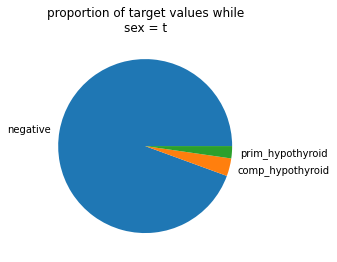

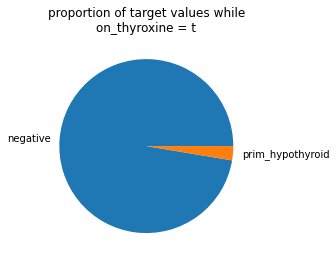

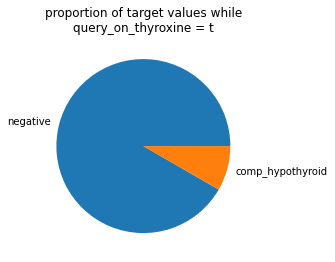

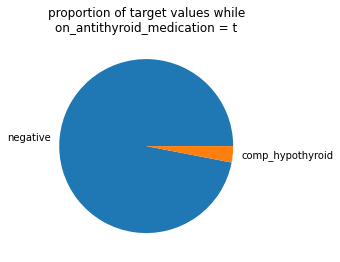

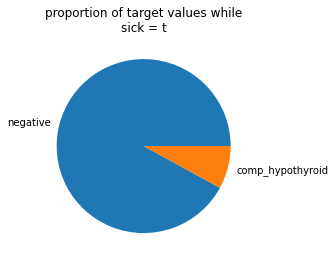

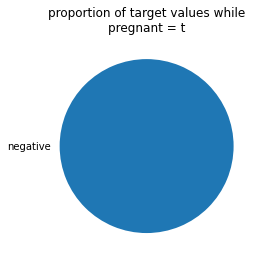

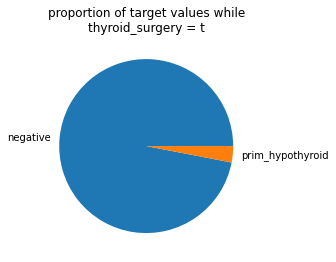

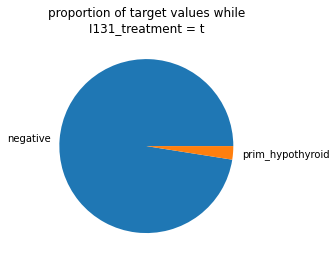

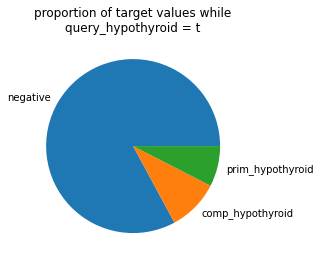

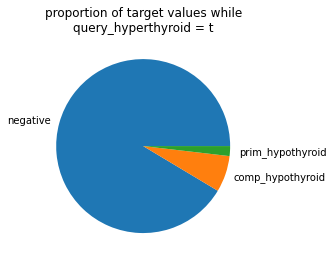

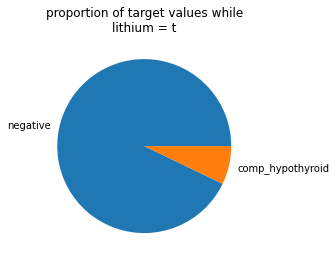

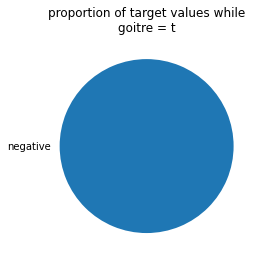

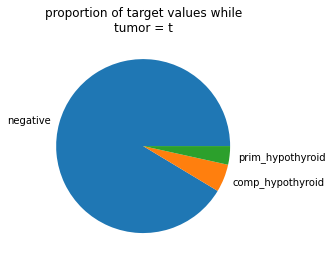

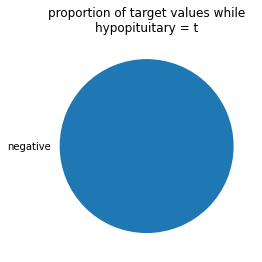

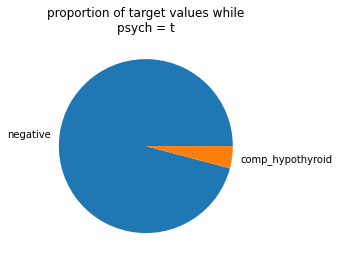

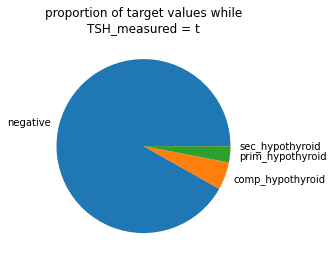

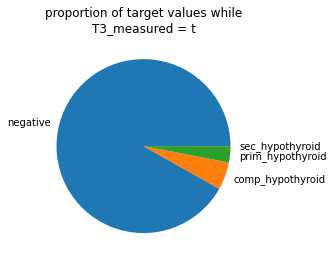

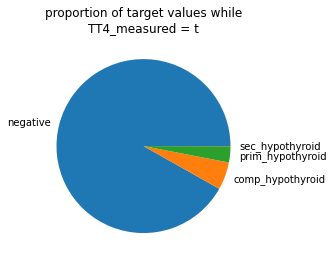

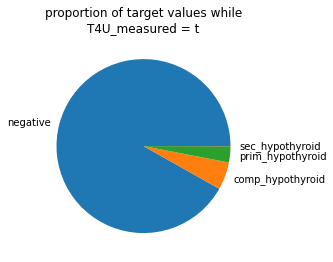

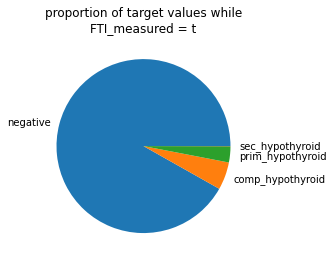

In [ ]:
for column in bin_columns_no_na:
  pie_info = data_no_na[data_no_na[column] == 1][target].value_counts()
  labels = pie_info.index.map(reverse_mapping)
  plt.pie(pie_info, labels=labels)
  plt.title(f'proportion of target values while\n{column} = t')
  plt.show()

Observations:
1. Here, we found why TBG is full of missed values. We see in TBG_measure that it wasn't just measured for any person --> TBG_measure turns out to be constant --> remove on DP step.
2.In all features, one of the variants ("f") prevails --> the values of the features are not balanced (same is for the target).We should pay attention to it while learning and evaluating model. Such dramatic disbalance will cause problems.

  Checking for target proportion didn't show that rare 't' values are strong signs of disease. (except, maybe, query_hypothyroid, where the proportion of non-negative classes is bigger compared to other features) --> We can use Variancethreshold to exclude low variance features. 
3. Hypopituitary seems also to be almost constant. Only one sample has 't' value. And it belongs to 'negative' target class, so if we remove this feature we won't lose any valued information about scanty target-classes. --> delete feature on DP step.


### 3.2 Explore statisticsfor numeric features

In [ ]:
data_no_na[numeric_columns].describe()

,age,TSH,T3,TT4,T4U,FTI
count,2643.000000,2643.000000,2643.000000,2643.000000,2643.000000,2643.000000
mean,53.081725,5.035978,2.001150,107.858683,0.995650,109.435906
std,20.367966,23.974851,0.823814,35.460437,0.196445,32.472156
min,1.000000,0.005000,0.050000,2.000000,0.250000,2.000000
25%,37.000000,0.500000,1.500000,88.000000,0.870000,93.000000
50%,55.000000,1.300000,2.000000,103.000000,0.980000,107.000000
75%,69.000000,2.600000,2.300000,124.000000,1.090000,124.000000
max,455.000000,530.000000,10.600000,430.000000,2.120000,395.000000


Some max values look like outliers or mistakes.

All features seem to be symetric because their means are close to the medians (except TSH: maybe there are many extreme outliers)

### 3.3 Explore distribution of numeric features

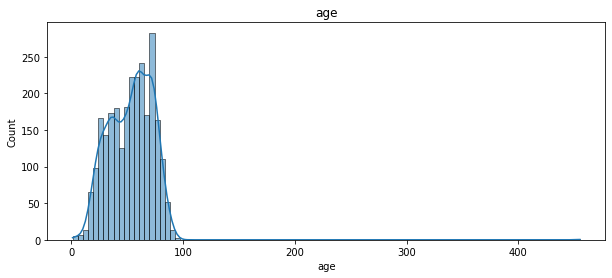

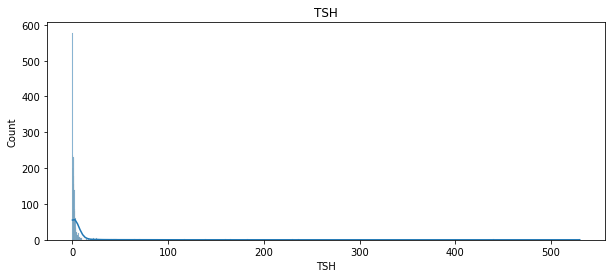

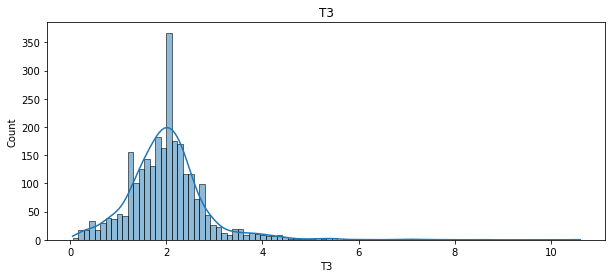

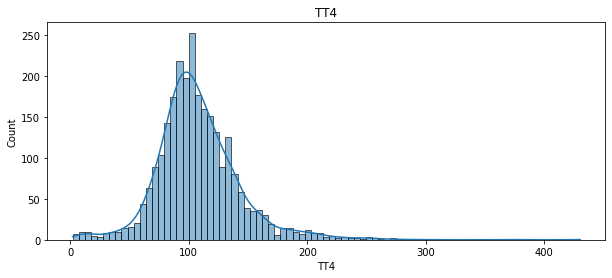

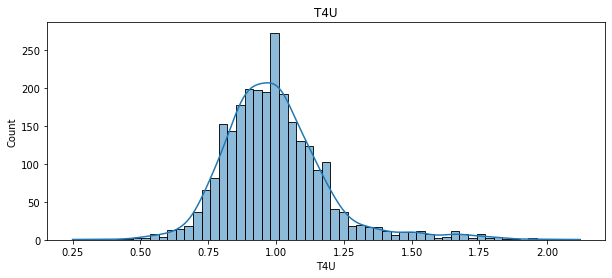

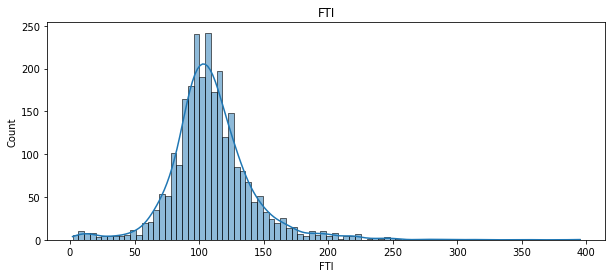

In [ ]:
for column in numeric_columns:
  data_hist = data_no_na[column]
  plt.figure(figsize=(10, 4))
  sns.histplot(data_hist, kde=True)
  plt.title(column)
  plt.show()

There are long tails in numeric featire distribution. That means there are some extreme values, which can negatively affect our model.

Age distribution seems to be symetric (if not to take into account extreme outliers) and has two modes.
T3, TT4, T4U and FTI distributions seem to be devote from normal distributed with positive kurtosis.

### 3.4. Outliers and Mistakes in numeric data

We should be very carefull when we want to delete any row. The reason is extreme disbalance in target classes. There some classes represented by very few samples. As a result, all these samples are truly valued.

Moreover, we are more interested in deviating values than in normal values as our main goal is to detect illness (i.e. deviating condition).

In [ ]:
def draw_pie(data: pd.DataFrame,
             column: str,
             upper_threshold: int or float = 0,
             lower_threshold: int or float = 0):
  
  if upper_threshold:
    pie_info = data[data[column] > upper_threshold]['Class'].value_counts() # threshold is choosen as it is the highest level of normal value according to the source
    labels = pie_info.index.map(reverse_mapping)
    plt.pie(pie_info, labels=labels)
    plt.title(f'Proportion of target classes for {column} > {upper_threshold}')
    plt.show()

  if lower_threshold:
    pie_info = data_no_na[data[column] < lower_threshold]['Class'].value_counts() # threshold is choosen as it is the lowest level of normal value according to the source
    labels = pie_info.index.map(reverse_mapping)
    plt.pie(pie_info, labels=labels)
    plt.title(f'Proportion of target classes for {column} < {lower_threshold}')
    plt.show()

  return

def draw_boxplot(data: pd.DataFrame,
                 column: str):
  plt.figure(figsize=(25, 3))
  sns.boxplot(data[column])
  plt.title(f'distribution of {column}')
  plt.show()

  return

def print_whiskers(feature: pd.Series):
  Q1 = np.percentile(feature, 25)
  Q3 = np.percentile(feature, 75)
  IQR = Q3 - Q1
  print(f'Left whisker: {Q1 - 1.5 * IQR}\nRight whisker: {Q3 + 1.5 * IQR}')

#### Feature "Age"

In [ ]:
data_no_na[data_no_na['age'] > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
1364,455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.1,1,2.0,1,118.0,1,1.13,1,104.0,SVI,0


Obviously, age = 455 is a mistake in data. --> delete on DP step.

In [ ]:
data_no_na = data_no_na[data_no_na['age'] != 455]

#### Feature "TSH" (Thyroid StimulatingHormone)

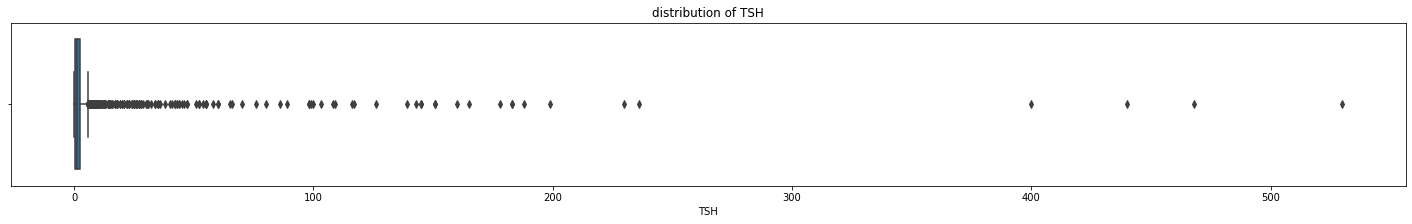

In [ ]:
draw_boxplot(data_no_na, 'TSH')

In [ ]:
# Quantiles
print_whiskers(data_no_na['TSH'])

Left whisker: -2.6500000000000004
Right whisker: 5.75


The range of the feature is pretty small and the range of the outliers is large.

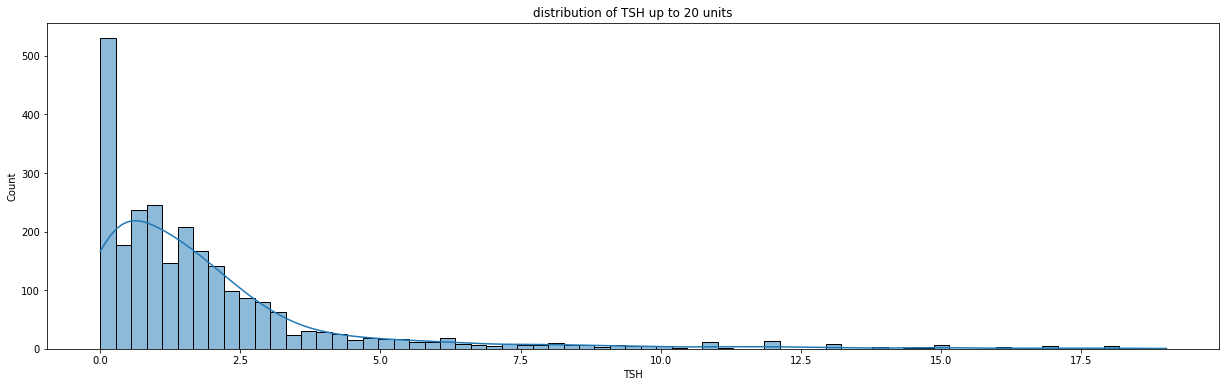

In [ ]:
plt.figure(figsize=(21, 6))
sns.histplot(data_no_na[data_no_na['TSH'] < 20]['TSH'], kde=True)
plt.title('distribution of TSH up to 20 units')
plt.show()

In the dataset discription, I didn't find what units of measurement were used, but after some internet research I can conclude that it is mIU/L (as most of the values are obseved in the range from 0 to ~5).
According to [this source](https://synlab.ee/ru/vrachu/laboratornyiy-spravochnik/interpretatsiya-rezultatov/immunologicheskie-issledovaniya/tireotropin-ili-gormon-stimuliruyushhiy-shhitovidnuyu-zhelezu-s-tsh/), normal value for TSH is 0.4-4.0 mIU/L and [for pregnant women and elderly people](https://newlab-med.ru/paczientam/kompleksyi-laboratornyix-issledovanij/laboratornaya-diagnostika-zabolevanij-shhitovidnoj-zhelezyi.html) up to 5.2 and 7.0 respectively. 
Unfortunately, I could not find what possible maximum value for TSH is, that's why we could not consider such large values as outliers, as it could be normal numbers for sickness. (And the next code cells prove it: the majority of target classes are not negative while TSH > 7).


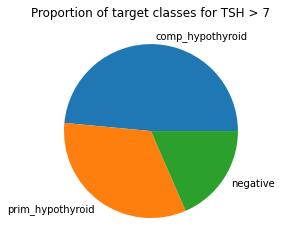

In [ ]:
draw_pie(data_no_na, 'TSH', 7)

As a result --> We keep all the values in dataset for TSH.

#### Feature "T3" (Triiodothyronine)

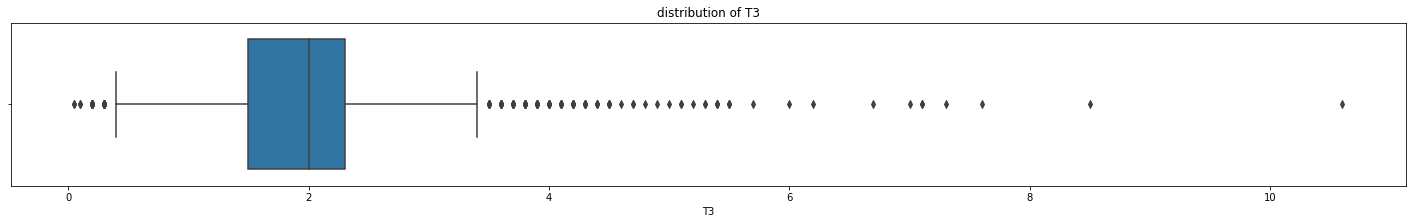

In [ ]:
draw_boxplot(data_no_na, 'T3')

Here, outliers' range is not so large as for TSH, but still there are some of them.
According to [this source](https://helix.ru/kb/item/08-113), the normal values are from 1 to 4 nmol/l; on our boxplot from ~0.3 to ~3.5.

In [ ]:
print_whiskers(data_no_na['T3'])

Left whisker: 0.30000000000000027
Right whisker: 3.4999999999999996


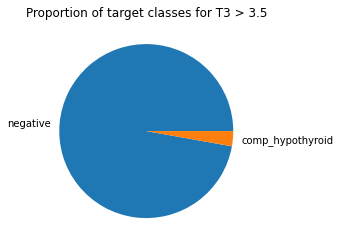

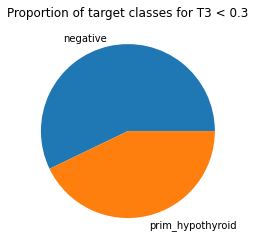

In [ ]:
draw_pie(data_no_na, 'T3', 3.5, 0.3)

 Interesting that while T3 is > 3.5 (which is out of the normal value), the target class is mostly negative. Low T3 may indicate sickness.

#### Feature "TT4" (Total Thyroxine)

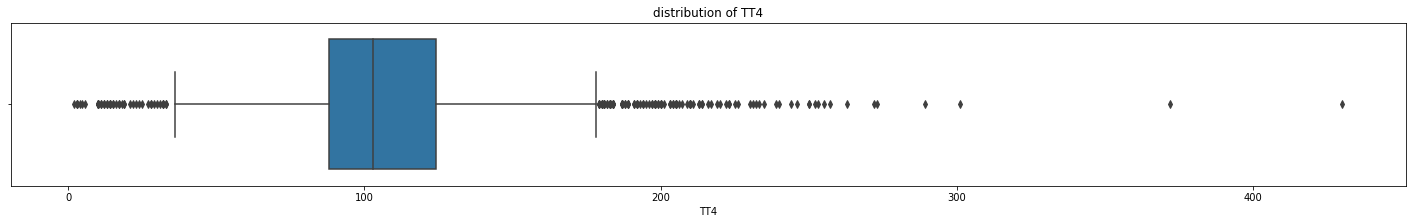

In [ ]:
draw_boxplot(data_no_na, 'TT4')

According to [this source](https://helix.ru/kb/item/08-115) normal values are 66 - 181 nmol/l. The range on our boxplot is nearly the same.

In [ ]:
print_whiskers(data_no_na['TT4'])

Left whisker: 34.0
Right whisker: 178.0


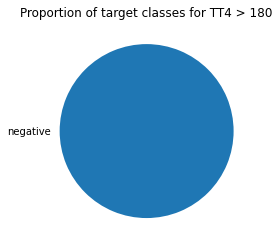

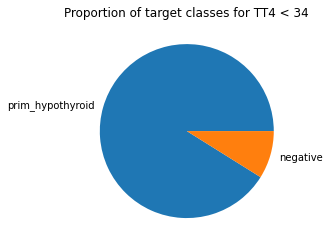

In [ ]:
draw_pie(data_no_na, 'TT4', 180, 34)

The target classes for TT4 > 180 are all negative, but fot TT4 < 50 the situation is opposite --> low TT4 is a sign of disease (and this is a valued information).

#### Feature "T4U" 

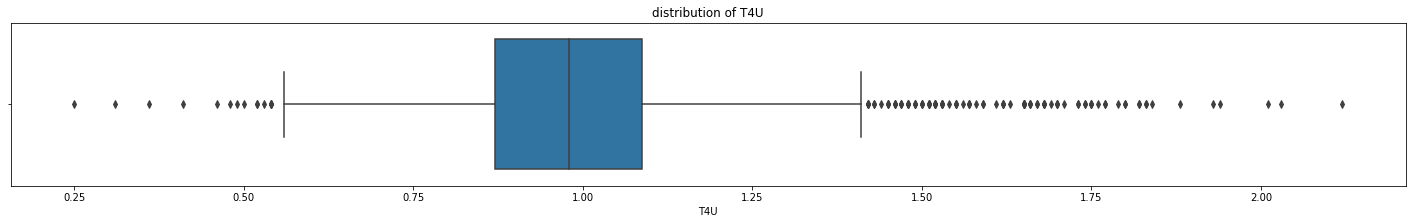

In [ ]:
draw_boxplot(data_no_na, 'T4U')

I could not find what "TU4" means and consider to establish "normal range" looking at the boxplot

In [ ]:
print_whiskers(data_no_na['T4U'])

Left whisker: 0.5437499999999997
Right whisker: 1.4137500000000003


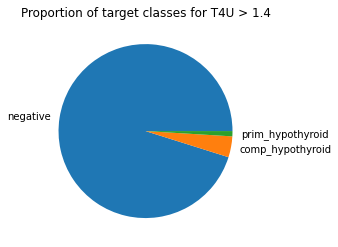

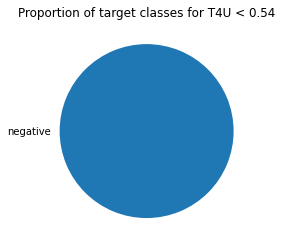

In [ ]:
draw_pie(data_no_na, 'T4U', 1.4, 0.54)

We can see some non-negative classes when T4U is low.

#### Feature "FTI" (The free T4 index)

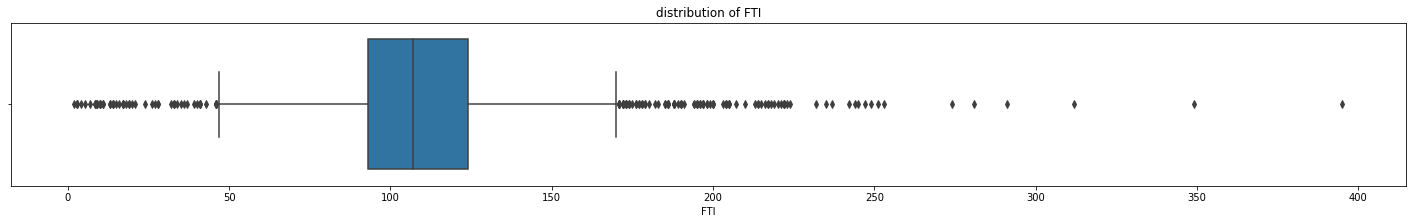

In [ ]:
draw_boxplot(data_no_na, 'FTI')

According to [it](https://www.verywellhealth.com/free-t4-index-procedure-4628291) the typical range for free T4 is between .8 and 1.8 nanograms per deciliter.
If we transform this feature by dividing by 100.

In [ ]:
data_no_na['FTI'] = data_no_na['FTI'].apply(lambda x: x / 100)

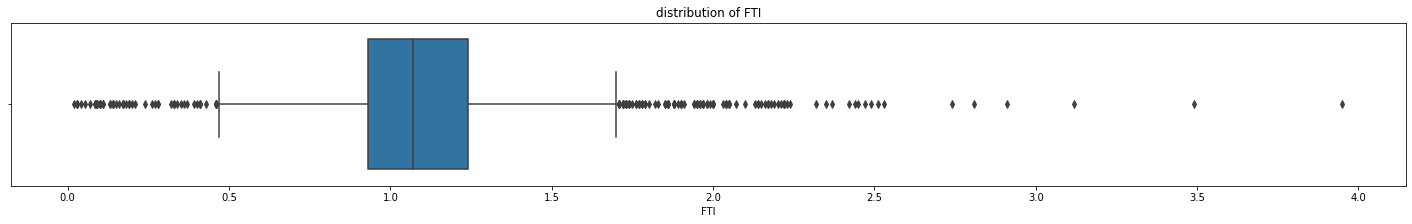

In [ ]:
draw_boxplot(data_no_na, 'FTI')

In [ ]:
print_whiskers(data_no_na['FTI'])

Left whisker: 0.46500000000000014
Right whisker: 1.7049999999999998


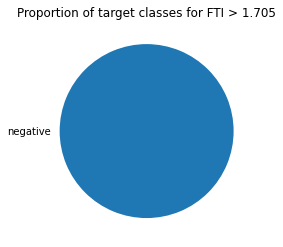

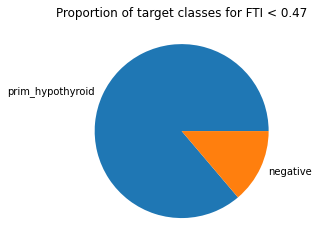

In [ ]:
draw_pie(data_no_na, 'FTI', 1.705, 0.47)

Low FTI is a sign of primary hypothyroid.

## Step 4. Multivariative analysis

### 4.1 pair relations

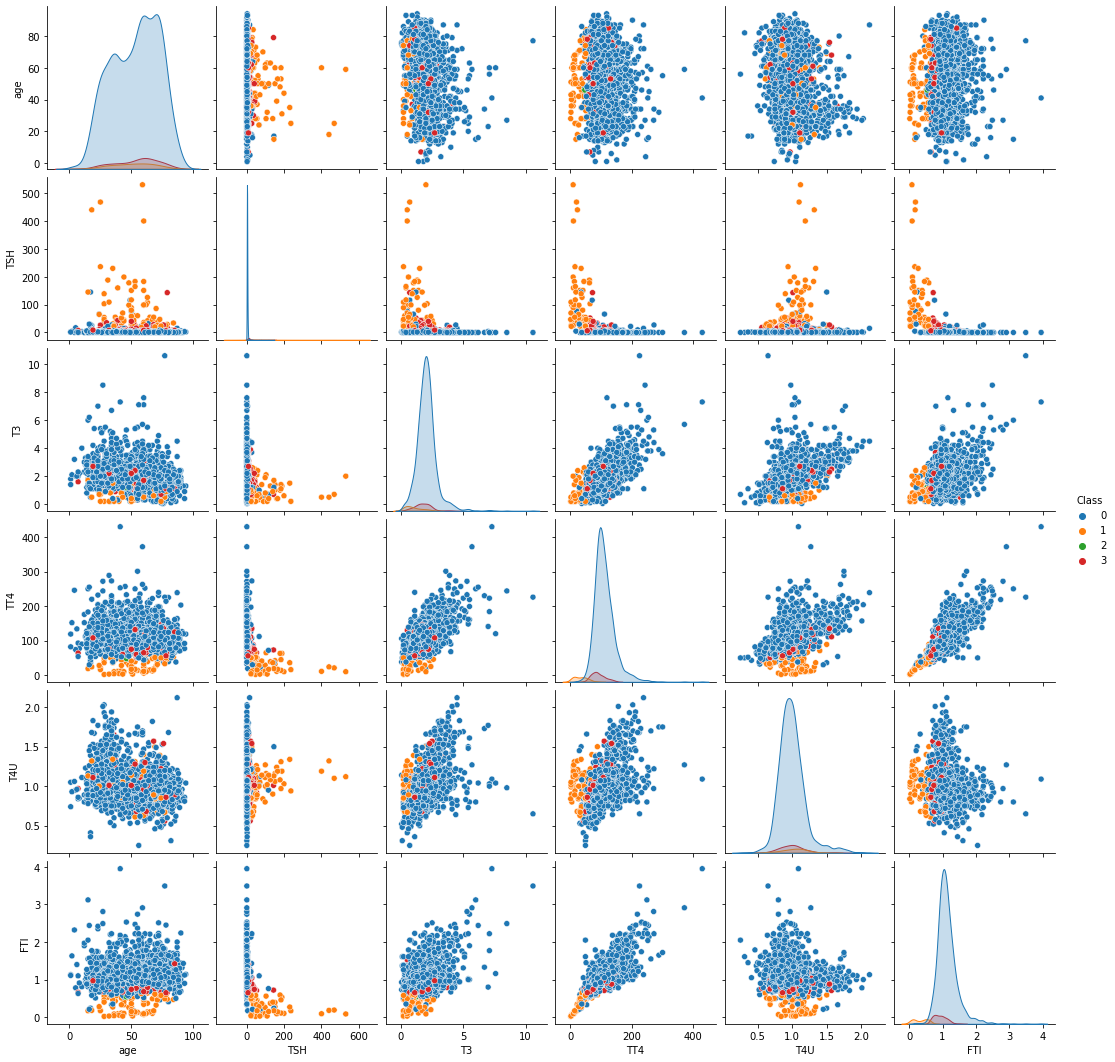

In [ ]:
sns.pairplot(data_no_na[numeric_columns + [target]], hue='Class', palette='tab10')
plt.show()

We see that on some plots target classes are well distinguishable. Especially, primary hypothyroid (labek 1) is visually separated from two others. (e.g. in FTI or TSH rows). The compensated hypothyroid (label 3) is really mixed uo with negative class (label 0). I expect that it will be very difficult for the model to distinguish it.

### 4.2 correlation within numeric features

In [ ]:
data_corr = data_no_na[numeric_columns].corr()

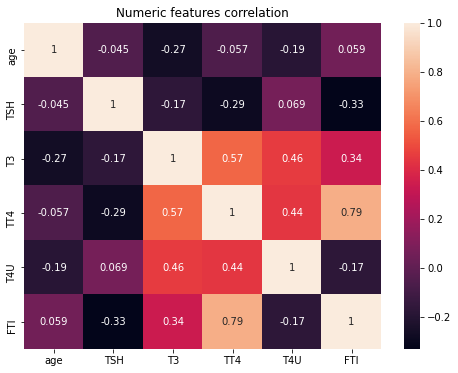

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(data_corr, annot=True)
plt.title('Numeric features correlation')
plt.show()

Multicolleration is observed. We can see the strongest correlation between FTI and TT4. It can be explaned as FTI is Index of FTI.

The correlation between TT4 and T3 is also > 50.

### 4.3 dependency of binary features and the target

As we need to find out correlation between non-negative boolean and categorical features, we are going to use [chi2](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html)

H0 - target and the column are independent

H1 - target and the column are dependent

In [ ]:
dependency = []
for column in bin_columns_no_na:
  _, p, _, _ = chi2_contingency(pd.crosstab(data_no_na[column], data_no_na[target]))
  if p < 0.05:
    dependency.append([p, '+++', 'reject H0: dependent'])
  else:
    dependency.append([p, '---', 'fail to reject H0: independent'])
dependency_res = pd.DataFrame(dependency, columns=[ 'p', 'status', 'comment'])
dependency_res.index = bin_columns_no_na

In [ ]:
dependency_res

,p,status,comment
sex,0.005953,+++,reject H0: dependent
on_thyroxine,0.000915,+++,reject H0: dependent
query_on_thyroxine,0.750377,---,fail to reject H0: independent
on_antithyroid_medication,0.705709,---,fail to reject H0: independent
sick,0.145061,---,fail to reject H0: independent
pregnant,0.294771,---,fail to reject H0: independent
thyroid_surgery,0.608564,---,fail to reject H0: independent
I131_treatment,0.516135,---,fail to reject H0: independent
query_hypothyroid,0.000440,+++,reject H0: dependent
query_hyperthyroid,0.636553,---,fail to reject H0: independent


According to chi2 hypothesis test, only 3 features are dependent on the target.

# 2. Data Preprocessing

## Step 1. Data preparation: fix data types and delete mistakes and constant features

Before feature transformation, we should prepare data first. Only then on prepared data, we will make transformations which are requested (i.e. imputing missing data, scale, log transform, feature selection etc.)

In [8]:
data_new_type = fix_datatype(data, bin_columns, numeric_columns)
pr_data = data_new_type[data_new_type['age'] <= 100]
pr_data['FTI'] = pr_data['FTI'].apply(lambda x: x / 100)

### 1.2 Delete low-variance feature or don't...
### What features are more important?
Let's prove that low variance features are not very usefull by some numbers.

It is expected that low variance features will give us less information for differentiation of target classes. To find it out, I will use selectKBest from sklearn with score function chi2.

In [ ]:
def draw_bars(x, height, title='', color='b'):
  plt.figure(figsize=(20, 6))
  plt.yscale('log')
  plt.xticks(rotation=40)
  plt.bar(x=x, height=height, color=color)
  plt.title(title)
  plt.show()

For drawing graphs, I am going to delete cat_column (as it is not encoded yet) and TBG and TBG_measured with zero variance. Also, I am going to drop NANs.


In [ ]:
data_select = pr_data.drop([cat_column, 'TBG_measured', 'TBG'], axis=1).replace(-1, np.nan).dropna()
X_pr_data = data_select.drop(target, axis=1)
y_pr_data = data_select[target]

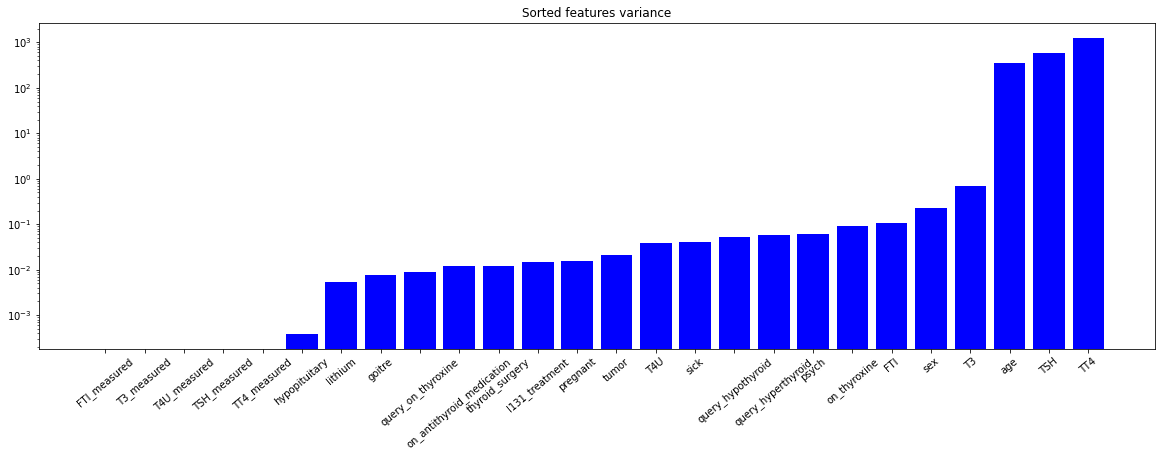

In [ ]:
var_res = sorted([(np.var(X_pr_data[column]), column) for column in X_pr_data])
x_var = [i[1] for i in var_res]
height_var = [i[0] for i in var_res]
draw_bars(x_var, height_var, 'Sorted features variance')

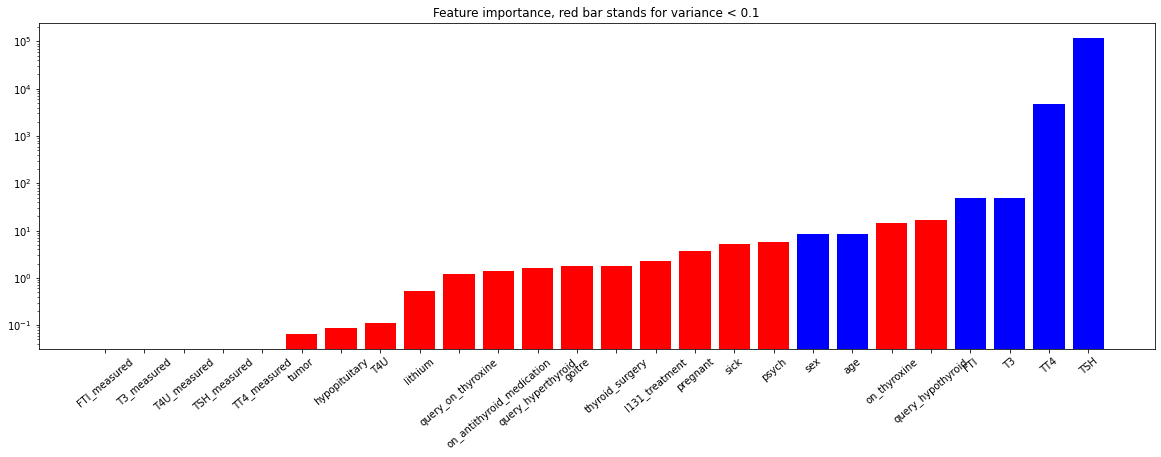

In [ ]:
top_scores = SelectKBest(chi2, k=20).fit(X_pr_data, y_pr_data).scores_
top_features = [(top_scores[i], X_pr_data.columns[i]) for i in range(len(X_pr_data.columns))]

x_labels = []
height_labels = []
for h, w in sorted(top_features):
  height_labels.append(h)
  x_labels.append(w)

color = ['r' if height_var[x_var.index(f)] < 0.1 else 'b' for f in x_labels]
draw_bars(x_labels, height_labels, 'Feature importance, red bar stands for variance < 0.1', color)

Now, we see that usually the higher is variance, the higher is chi2 score, but we see also that sex and age with variance > 0.1 got lower chi2 score than some features with variance < 0.1).



In [10]:
pr_data = pr_data[['TSH', 'TT4', 'T3', 'FTI', 'on_thyroxine', 'query_hypothyroid', 
                   'age', 'sex', cat_column, 'tumor', 'hypopituitary', 'lithium', 
                   'query_on_thyroxine', 'on_antithyroid_medication', 'query_hyperthyroid', 'goitre',
                   'thyroid_surgery', 'I131_treatment', 'pregnant', 'sick', 'psych',
                   target]]

In [11]:
numeric_columns = ['TSH', 'TT4', 'T3', 'FTI', 'age']
bin_columns = ['on_thyroxine', 'query_hypothyroid', 'sex']
numeric_and_target_columns = numeric_columns + [target]

## Step 2. Transformations

### 2.1 Oversample minor classes
secondary_hypothyroid class is the main problem here: we have to split our data at least in 3 group: train, validation and test. In secondary_hypothyroid, we have only two samples. Possible solutions:
1. Decide to delete these two samples and imagine that they have never existed (bad solution)
2. Copy the given samples and train-test-validate only on them (also no good solution.)
3. Resample (may work), but still we have to few points for it. We should resample after spliting, only then we will we only one sample in each subdataset. (But we can apply it to other two minor classes.)

So, then the best decision would be to drop this class.

In [24]:
pr_data = pr_data[pr_data['Class'] != 3]

### 2.3 Train-test split

In [54]:
def draw_target_pie(y: pd.core.series.Series,
                    title: str='Distribution of y'):
    pie_info = pd.Series(y).value_counts()
    plt.pie(pie_info, labels=pie_info.index)
    plt.title(title)
    plt.show()  

    return

In [ ]:
pr_data = pr_data[pr_data['age'] <= 100]  # delete mistake
pr_data['FTI'] = pr_data['FTI'].apply(lambda x: x / 100) # scale

In [38]:
X = pr_data.drop('Class', axis=1)
y = pr_data['Class']

In [39]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=0, 
                                                    shuffle=True, test_size=0.3,
                                                    stratify=y)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, 
                                                    shuffle=True, test_size=0.3,
                                                    stratify=y_train_val)

### 2.3 Data transformation (Pipeline)

Why was chosen this or that transformation?
* KNN imputer: to imput Nans based on many features.
* MinMaxscaler: to scale numeric features to interval from 0 to 1 (I think this is more natural for this type of data (concentration of different hormones in the blood) than the range (-1, 1) (StandartScaler).
* log transform: as we saw on EDA step, the distribution of the numeric features are not perfectly normal(positive kurtosis, 2 modes etc.) Log transform will make it more normal.
* get_dummies: It was choosen because the categorical features do not have many unique values and we can not define any order within the values (thar's also the reason not to implement OrdinalEncoding).
* SMOTE: There is a problem of imbalance in the data. SMOTE is implemeted to reduce it. I don't want to make a lot of noise in our data as I am afraid that this will negatively affect the model.So we will increse 1 number by 50%
* TomekLinks: to dicrese a bit negative class samples number.

In [30]:
# drop 3rd class because there are only 2 samples
data = data[data['Class'] != 'secondary_hypothyroid']

In [45]:
from sklearn.base import TransformerMixin, BaseEstimator
class Transformer(BaseEstimator, TransformerMixin):
  """
  Applies required transformations to the features depending on their datatype
  """
  def __init__(self, numeric_columns, bin_columns):
    self.X = pd.DataFrame()
    self.y = pd.Series()
    self.numeric_columns = numeric_columns
    self.bin_columns = bin_columns
  
  def fit(self, X, y=None):
    self.X = X
    self.y = y
    return self

  def _transform_num(self, X, y=None):
    columns = X.columns

    knn = KNNImputer(n_neighbors=5, missing_values=-1)
    X = knn.fit_transform(X)

    scale = StandardScaler()
    X = scale.fit_transform(X)

    return pd.DataFrame(X, columns=columns)

  def _transform_bin(self, X, y=None):
    columns = X.columns
    knn = KNNImputer(n_neighbors=2, missing_values=-1)
    X = pd.DataFrame(knn.fit_transform(X))
    return X
    
  def transform(self, oversampling=False, undersampling=False, ratio_over={}):
      self.X.index = [i for i in range(len(self.X))]

      num_df = self._transform_num(self.X[self.numeric_columns])
      bin_df = self._transform_bin(self.X[self.bin_columns])
      full_df = pd.concat([num_df, bin_df], axis=1)
      columns = full_df.columns
      full_y = self.y
      index = self.X.index

      if oversampling:
          smote = SMOTE(sampling_strategy=ratio_over, k_neighbors=1)
          full_df, full_y = smote.fit_resample(full_df, self.y)
          index = [i for i in range(len(full_df))]
      
      if undersampling:
          tl = TomekLinks(sampling_strategy='majority')
          full_df, full_y = tl.fit_resample(full_df, full_y)
          index = tl.sample_indices_


      return full_df, np.array(full_y)

X = pr_data.drop(['referral_source', 'Class'], axis=1)
y = pr_data['Class']


train, test = train_test_split(list(range(X.shape[0])), test_size=.3)

transform = Transformer(numeric_columns=numeric_columns,  
            bin_columns=bin_columns)
transform.fit(X.iloc[train, :], y.iloc[train])
counts = y.value_counts() * 10
counts = counts.apply(int)
X_train_tr, y_train_tr = transform.transform(oversampling=True, undersampling=True,
                                  ratio_over={1: counts[1], 
                                              2: counts[2]})

In [46]:
transform = Transformer(numeric_columns=numeric_columns,  
            bin_columns=bin_columns)
transform.fit(X.iloc[test, :], y.iloc[test])
counts = y.value_counts() * 10
counts = counts.apply(int)
X_val_tr, y_val_tr = transform.transform(oversampling=False, undersampling=False)

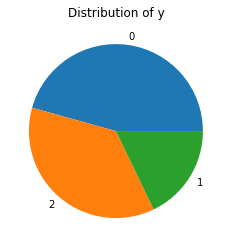

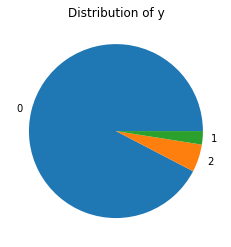

In [55]:
draw_target_pie(y_train_tr)
draw_target_pie(y_train)

# 3. Modeling and evaluating

## Metric to evaluate
As our data is very imbalanced and we have multiclassification problem:
* We are NOT going to use Accuracy.
* We are going to use Precision (to be sure that the model predicts illnesses precise, to dicrease misdiagnoses, i.e proportion of patients that we diagnosed as  (not) having disease, actually (didn't have) had it)
* We are going to use recall and give it priority (to get the propotion of correctly predicted labels to true values)
*cross entropy
* macro-average: to aggregate the contributions of all classes to compute the average metric.

In [85]:
def evaluate_model(y_pred, y_true, y_pred_proba):
  df = []
  df.append(precision_score(y_true, y_pred, average=None))
  df.append(recall_score(y_true, y_pred, average=None))
  columns = pd.Series([0, 1, 2]).map({0: 'negative', 
                                      1: 'prim_hypothyroid', 
                                      2: 'comp_hypothyroid'})

  scores = pd.DataFrame(df, index=['Precision', 'Recall'], 
                        columns=columns).T

  total_scores = pd.DataFrame([precision_score(y_true, y_pred, average='macro'),
                               recall_score(y_true, y_pred, average='macro'),
                               log_loss(y_true, y_pred_proba)],
                              index=['Precision macro', 
                                     'Recall macro', 
                                     'Log_loss'],
                              columns=['Value']).T


  conf_matrix = pd.crosstab(y_true, y_pred)
  conf_matrix.columns = columns
  conf_matrix.index = columns
  return scores, total_scores, conf_matrix


def display_scores(scores, total_scores, conf_matrix):
  print('Confusion matrix')
  display(conf_matrix)
  print('\n')
  print('Scores for each class')
  display(scores)
  print('\n')
  print('Total scores')
  display(total_scores)

  return

In [57]:
scorer = make_scorer(f1_score, average='weighted')

log_parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 1.0, 2.0, 10.0],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None]
}
log_clf = LogisticRegression()
grid_log = GridSearchCV(log_clf, log_parameters, scoring=scorer)
grid_log.fit(X_train_tr, y_train_tr)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 2.0, 10.0],
                         'class_weight': ['balanced', None],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring=make_scorer(f1_score, average=weighted))

In [58]:
grid_log.best_params_

{'C': 10.0, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}

In [59]:
log_clf = LogisticRegression(**grid_log.best_params_)
log_clf.fit(X_train_tr, y_train_tr)

GridSearch chose l2-penalty. Lets try log regression without regularization and see how different other parameters will be.

In [60]:
log_parameters_no_reg = {
    'penalty': ['none'],
    'C': [0.1, 1.0, 2.0, 10.0],
    'fit_intercept': [True, False],
    'class_weight': ['balanced', None]
}
log_clf_no_reg = LogisticRegression()
grid_log_no_reg = GridSearchCV(log_clf_no_reg, log_parameters_no_reg, scoring=scorer)
grid_log_no_reg.fit(X_train_tr, y_train_tr)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 2.0, 10.0],
                         'class_weight': ['balanced', None],
                         'fit_intercept': [True, False], 'penalty': ['none']},
             scoring=make_scorer(f1_score, average=weighted))

In [61]:
grid_log_no_reg.best_params_

{'C': 0.1,
 'class_weight': 'balanced',
 'fit_intercept': True,
 'penalty': 'none'}

How interesting! All the parameters have changed. C got very small, class weight -- balanced, fit_intercept -- False.

In [62]:
log_clf_no_reg = LogisticRegression(**grid_log_no_reg.best_params_)
log_clf_no_reg.fit(X_train_tr, y_train_tr)

In [63]:
knn_parameters = {
    'n_neighbors': [2, 3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [ 3, 4, 5, 10],
    'p': [1, 2],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}
knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, knn_parameters, scoring=scorer)
grid_knn.fit(X_train_tr, y_train_tr)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [3, 4, 5, 10],
                         'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski'],
                         'n_neighbors': [2, 3, 5, 7, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring=make_scorer(f1_score, average=weighted))

In [64]:
knn_clf = KNeighborsClassifier(**grid_knn.best_params_)
knn_clf.fit(X_train_tr, y_train_tr)

In [86]:
print('===Logistic with regularization===')
y_pred = log_clf.predict(X_val_tr)
y_pred_proba = log_clf.predict_proba(X_val_tr)
log_scores, log_total_scores, log_conf_matrix = evaluate_model(y_pred, y_val_tr, y_pred_proba)
display_scores(log_scores, log_total_scores, log_conf_matrix)

===Logistic with regularization===
Confusion matrix


,negative,prim_hypothyroid,comp_hypothyroid
negative,981,28,41
prim_hypothyroid,0,27,3
comp_hypothyroid,4,5,42




Scores for each class


,Precision,Recall
negative,0.995939,0.934286
prim_hypothyroid,0.450000,0.900000
comp_hypothyroid,0.488372,0.823529




Total scores


,Precision macro,Recall macro,Log_loss
Value,0.64477,0.885938,0.386524


In [87]:
print('===Logistic without regularization===')
y_pred = log_clf_no_reg.predict(X_val_tr)
y_pred_proba = log_clf_no_reg.predict_proba(X_val_tr)
log_scores_no_reg, log_total_scores_no_reg, log_conf_matrix_no_reg = evaluate_model(y_pred, y_val_tr, y_pred_proba)
display_scores(log_scores_no_reg, log_total_scores_no_reg, log_conf_matrix_no_reg)

===Logistic without regularization===
Confusion matrix


,negative,prim_hypothyroid,comp_hypothyroid
negative,981,28,41
prim_hypothyroid,0,27,3
comp_hypothyroid,4,6,41




Scores for each class


,Precision,Recall
negative,0.995939,0.934286
prim_hypothyroid,0.442623,0.900000
comp_hypothyroid,0.482353,0.803922




Total scores


,Precision macro,Recall macro,Log_loss
Value,0.640305,0.879402,0.386162


In [88]:
print('=== KNN ===')
y_pred = knn_clf.predict(X_val_tr)
y_pred_proba = knn_clf.predict_proba(X_val_tr)
knn_scores, knn_total_scores, knn_conf_matrix = evaluate_model(y_pred, y_val_tr, y_pred_proba)
display_scores(knn_scores, knn_total_scores, knn_conf_matrix)

=== KNN ===
Confusion matrix


,negative,prim_hypothyroid,comp_hypothyroid
negative,1031,2,17
prim_hypothyroid,5,20,5
comp_hypothyroid,30,2,19




Scores for each class


,Precision,Recall
negative,0.967167,0.981905
prim_hypothyroid,0.833333,0.666667
comp_hypothyroid,0.463415,0.372549




Total scores


,Precision macro,Recall macro,Log_loss
Value,0.754638,0.673707,1.611891


* **Note**: here, if "log" or "log regression" is written, that means logistic regression WITH regularization. "Logistic regression without regularization" is always specified. Sometimes, both logistic model can be joint as "log models" or something like this.

**Conclusion**:

All models predict negative class pretty well, as expected. But pretty often is mislabeled as having disease.
Overall, logistic regression with regularization seem to fit our data better than logistic regression withut regularization and K-Neighrest-Neihbors Classifier. 